# Machine Learning: Homework 3 - Jose Vazquez-Espinoza

Algorithm's implementation in: https://github.com/

## Part 1:

EM as a minorization algorithm (Hunter and Lange, 2004; Wu and Lange, 2007). A function $g(x,y)$ to said to minorize a function $f(x)$ if

$$g(x,y) \leq f(x), g(x,x) = f(x)$$

for all $x, y$ in the domain. This is useful for maximizing $f(x)$ since is easy to show that $f(x)$ is non-decreasing under the update

$$x^{s+1} = argmax_x g(x,x^s)$$

There are analogous definitions for majorization, for minimizing a function $f(x)$. The resulting algorithms are known as MM algorithms, for “Minorize-Maximize” or “Majorize-Minimize.”

Show that the EM algorithm (Section 8.5.2) is an example of an MM al-gorithm, using $Q(\theta′,\theta)+\log P(Z|\theta)−Q(\theta, \theta)$ to minorize the observed data log-likelihood $l(\theta′; Z)$. (Note that only the first term involves the relevant
parameter $\theta′$).

## Part 2:

### Problem (a):
Consider a Gaussian mixture model in which the marginal distribution $p(z)$ for the latent variable is given by (9.10), and the conditional distribution $p(x|z)$ for the observed variable is given by (9.11). Show that the marginal distribution $p(x)$, obtained by summing $p(z)p(x|z)$ over all possible values of $z$, is a Gaussian
mixture of the form (9.7).

### Problem (b):
Consider a mixture distribution of the form
$$p(x) = \sum_{k=1}^K \pi_k p(\mathbf{x}|k)$$
where the elements of $x$ could be discrete or continuous or a combination of these.
Denote the mean and covariance of $p(x|k)$ by $μ_k$ and $\Sigma_k$ , respectively. Show that
the mean and covariance of the mixture distribution are given by (9.49) and (9.50).

## Part 3:

Implement using Python the EM algorithm for the mixture of Gaussians. 
    

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import random
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split #Just for metrics
%matplotlib inline

#Implementation of Own Algorithm
from ML_Algorithms import GaussianMixtures as gm
from ML_Algorithms import Optimization_methods as om
from ML_Algorithms import Classifiers

After this:
* Create two classes composed of k Gaussians splitting the set in

    1. 90% random training data
    2. 10% random testing data

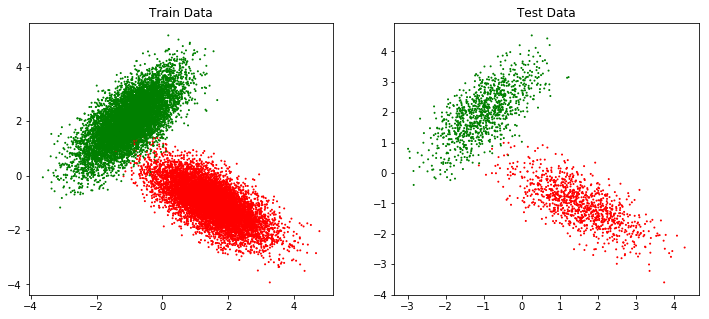

In [2]:
#Data set Initialization

no_samples = 10000

std = [[0.5, 0.4], [0.4,0.7]]
std2 = [[0.7, -0.4], [-0.4,0.5]]
c1 = np.random.multivariate_normal([-1, 2], std, no_samples);
c2 = np.random.multivariate_normal([1.5, -1], std2, no_samples);
X  = np.concatenate([c1,c2])

labels = np.ones(no_samples)
labels2 = 0 * np.ones(no_samples)
Y = np.concatenate([labels, labels2])
Y = Y.reshape((Y.shape[0], 1))

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=3)

label_train = list(y_train.ravel())
label_test = list(y_test.ravel())
colors = ['red','green']

f, axarr = plt.subplots(1, 2, figsize=(12,5))
axarr[0].scatter(X_train[:,0], X_train[:,1], c=label_train, 
                 cmap=matplotlib.colors.ListedColormap(colors), s = 1)
axarr[0].set_title("Train Data")
axarr[1].scatter(X_test[:,0], X_test[:,1], c=label_test, 
                 cmap=matplotlib.colors.ListedColormap(colors), s = 1)
axarr[1].set_title("Test Data")
plt.show()

    
* Adjust the Gaussian Mixture to such classes. 

Now we can run the expectation maximization algorith with two random gaussian distributions and we obtain an approximation of the mean and the covariance of the distributions used to generate the data.


In [3]:
#Initializing Gaussian Mixture model
mixture = gm.GaussianMixture(X, clusters=2)
mixture.fit(iters=6)

 dist 1
 mean: 
[[ 1.12260541]
 [-0.60322991]]
 covariance: 
[[ 1.44978916 -1.08834882]
 [-1.08834882  1.38458228]]
 dist 2
 mean: 
[[-1.01439804]
 [ 2.09941296]]
 covariance: 
[[ 0.52134238  0.41119313]
 [ 0.41119313  0.67748682]]


* Use naive Bayesian classification to build the Confusion Matrix of your experiments

## Part 4:

Now, that you have the concept of k-Cross Validation and Confusion Matrix. Please using
your previous algorithms

1. Linear Regression under Gradient Descent
2. Logistic Regression under Newton-Raphson

and data sets, please divide the data sets in training, validation and testing data sets and
provide the results for your previous experiments in terms of
1. Confusion Matrix
2. Accuracy and $F_1$ score
3. ROC curves

In [13]:
from ML_Algorithms import Logistic_Regression as logreg
from ML_Algorithms import Classifiers
from ML_Algorithms import utils

In [14]:
clf = logreg.Logistic_Regression()
clf.fit(X, Y, solver="gradient",step_size= 0.0001, tresh = 0.00001, max_iter = 100, reg = 10000, print_val=True)

steps: 100


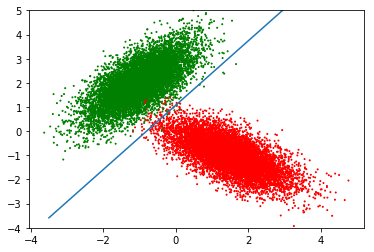

In [15]:
x = np.linspace(-3.5,3.5,100)
y =  -1/clf.coef[2] * (clf.coef[0] + clf.coef[1]* x)
plt.scatter(X_train[:,0], X_train[:,1], c=label_train, 
                 cmap=matplotlib.colors.ListedColormap(colors), s = 1)
plt.ylim((-4,5))
plt.plot(x,y)

In [20]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [17]:
from ML_Algorithms import metrics

Confussion matrix for Training set

In [19]:
metrics.confusion_matrix(y_train, y_train_pred)

array([[ 8995.,    71.],
       [   12.,  8922.]])

Confussion matrix for test test

In [21]:
metrics.confusion_matrix(y_test, y_test_pred)

array([[ 991.,   12.],
       [   2.,  995.]])